In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 42

In [4]:
def all_3bit_inputs():
    """Yield all combinations of 3 binary inputs (x1,x2,x3) as list of tuples."""
    return list(itertools.product([0, 1], repeat=3))

In [5]:
def logic_gates_3_inputs():
    rows = []
    for x1, x2, x3 in all_3bit_inputs():
        # Basic gates
        y_and = int(x1 and x2 and x3)
        y_or = int(x1 or x2 or x3)
        # NOR: not(OR)
        y_nor = int(not (x1 or x2 or x3))
        # XNOR of 3 bits: true when even parity (i.e., parity bit = 0)
        # XNOR for multi bits can be thought as NOT XOR -> parity even -> XNOR=1
        parity = (x1 + x2 + x3) % 2
        y_xnor = int(parity == 0)
        # NOT: ambiguous for 3-input - commonly NOT applied per-bit. We'll provide NOT of x1,x2,x3 separately as columns
        y_not_x1, y_not_x2, y_not_x3 = int(not x1), int(not x2), int(not x3)
        rows.append({
            "x1": x1, "x2": x2, "x3": x3,
            "y_AND": y_and, "y_OR": y_or, "y_NOR": y_nor, "y_XNOR": y_xnor,
            "y_NOT_x1": y_not_x1, "y_NOT_x2": y_not_x2, "y_NOT_x3": y_not_x3
        })
    return pd.DataFrame(rows)

In [6]:
def adder_3bit_full():
    """3-bit full-adder truth table for inputs x1,x2,x3: produce sum bit (y_sum) and carry bit (y_carry)."""
    rows = []
    for x1, x2, x3 in all_3bit_inputs():
        s = (x1 + x2 + x3) % 2
        c = 1 if (x1 + x2 + x3) >= 2 else 0  # carry-out when sum >= 2
        rows.append({"x1": x1, "x2": x2, "x3": x3, "y_sum": s, "y_carry": c})
    return pd.DataFrame(rows)

In [7]:
def decoder_3to8():
    """3-to-8 decoder: inputs (x1,x2,x3) produce outputs y0..y7 as one-hot where yN=1 corresponds to binary value (x1 x2 x3)."""
    rows = []
    for x1, x2, x3 in all_3bit_inputs():
        val = (x1 << 2) | (x2 << 1) | x3
        out = [0]*8
        out[val] = 1
        d = {"x1": x1, "x2": x2, "x3": x3}
        for i in range(8):
            d[f"y_{i}"] = out[i]
        rows.append(d)
    return pd.DataFrame(rows)

In [8]:
def encoder_8to3():
    """8-to-3 priority encoder-like truth table: input is 8 lines (i0..i7) one-hot. Output is the binary code of active line.
       When multiple ones appear we'll assume priority: highest index wins (i7 highest priority).
       But for 'all possible' we'll generate only valid one-hot inputs and also test multiple-high cases.
    """
    rows = []
    # Generate all 8 one-hot vectors (i0..i7)
    for idx in range(8):
        inputs = [1 if i == idx else 0 for i in range(8)]
        # binary encoding of idx as 3 bits (b2 b1 b0), b2 = MSB
        b2 = (idx >> 2) & 1
        b1 = (idx >> 1) & 1
        b0 = idx & 1
        d = {f"i{i}": inputs[i] for i in range(8)}
        d.update({"y2": b2, "y1": b1, "y0": b0})
        rows.append(d)
    # Additionally add a few multi-hot examples with defined priority (highest index)
    for multi in [(1,2), (0,3), (5,7), (2,6,7)]:
        inputs = [1 if i in multi else 0 for i in range(8)]
        idx = max(multi)  # priority: highest index
        b2 = (idx >> 2) & 1
        b1 = (idx >> 1) & 1
        b0 = idx & 1
        d = {f"i{i}": inputs[i] for i in range(8)}
        d.update({"y2": b2, "y1": b1, "y0": b0})
        rows.append(d)
    return pd.DataFrame(rows)

In [9]:
df_gates = logic_gates_3_inputs()
df_adder = adder_3bit_full()
df_decoder = decoder_3to8()
df_encoder = encoder_8to3()

In [10]:
df_enc_dec = {
    "decoder_3to8": df_decoder.copy(),
    "encoder_8to3": df_encoder.copy()
}

In [11]:
df_gates.to_csv("dataset_gates.csv", index=False)
df_adder.to_csv("dataset_adder.csv", index=False)
df_decoder.to_csv("dataset_decoder_3to8.csv", index=False)
df_encoder.to_csv("dataset_encoder_8to3.csv", index=False)

print("Datasets created and saved: dataset_gates.csv, dataset_adder.csv, dataset_decoder_3to8.csv, dataset_encoder_8to3.csv")

Datasets created and saved: dataset_gates.csv, dataset_adder.csv, dataset_decoder_3to8.csv, dataset_encoder_8to3.csv


In [12]:
def basic_eda(df, name="Data"):
    print("\n" + "="*40)
    print(f"EDA for: {name}")
    print("="*40)
    print("Shape:", df.shape)
    print("\nInfo:")
    print(df.info())
    print("\nDescribe:")
    print(df.describe(include='all'))
    print("\nHead:")
    print(df.head())

In [13]:
basic_eda(df_gates, "Gates (3-input)")
basic_eda(df_adder, "3-bit Adder")
basic_eda(df_decoder, "Decoder 3->8")
basic_eda(df_encoder, "Encoder 8->3 (one-hot + priority extras)")


EDA for: Gates (3-input)
Shape: (8, 10)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   x1        8 non-null      int64
 1   x2        8 non-null      int64
 2   x3        8 non-null      int64
 3   y_AND     8 non-null      int64
 4   y_OR      8 non-null      int64
 5   y_NOR     8 non-null      int64
 6   y_XNOR    8 non-null      int64
 7   y_NOT_x1  8 non-null      int64
 8   y_NOT_x2  8 non-null      int64
 9   y_NOT_x3  8 non-null      int64
dtypes: int64(10)
memory usage: 772.0 bytes
None

Describe:
             x1        x2        x3     y_AND      y_OR     y_NOR    y_XNOR  \
count  8.000000  8.000000  8.000000  8.000000  8.000000  8.000000  8.000000   
mean   0.500000  0.500000  0.500000  0.125000  0.875000  0.125000  0.500000   
std    0.534522  0.534522  0.534522  0.353553  0.353553  0.353553  0.534522   
min    0.000000  0.000000  0.00

<Figure size 800x600 with 0 Axes>

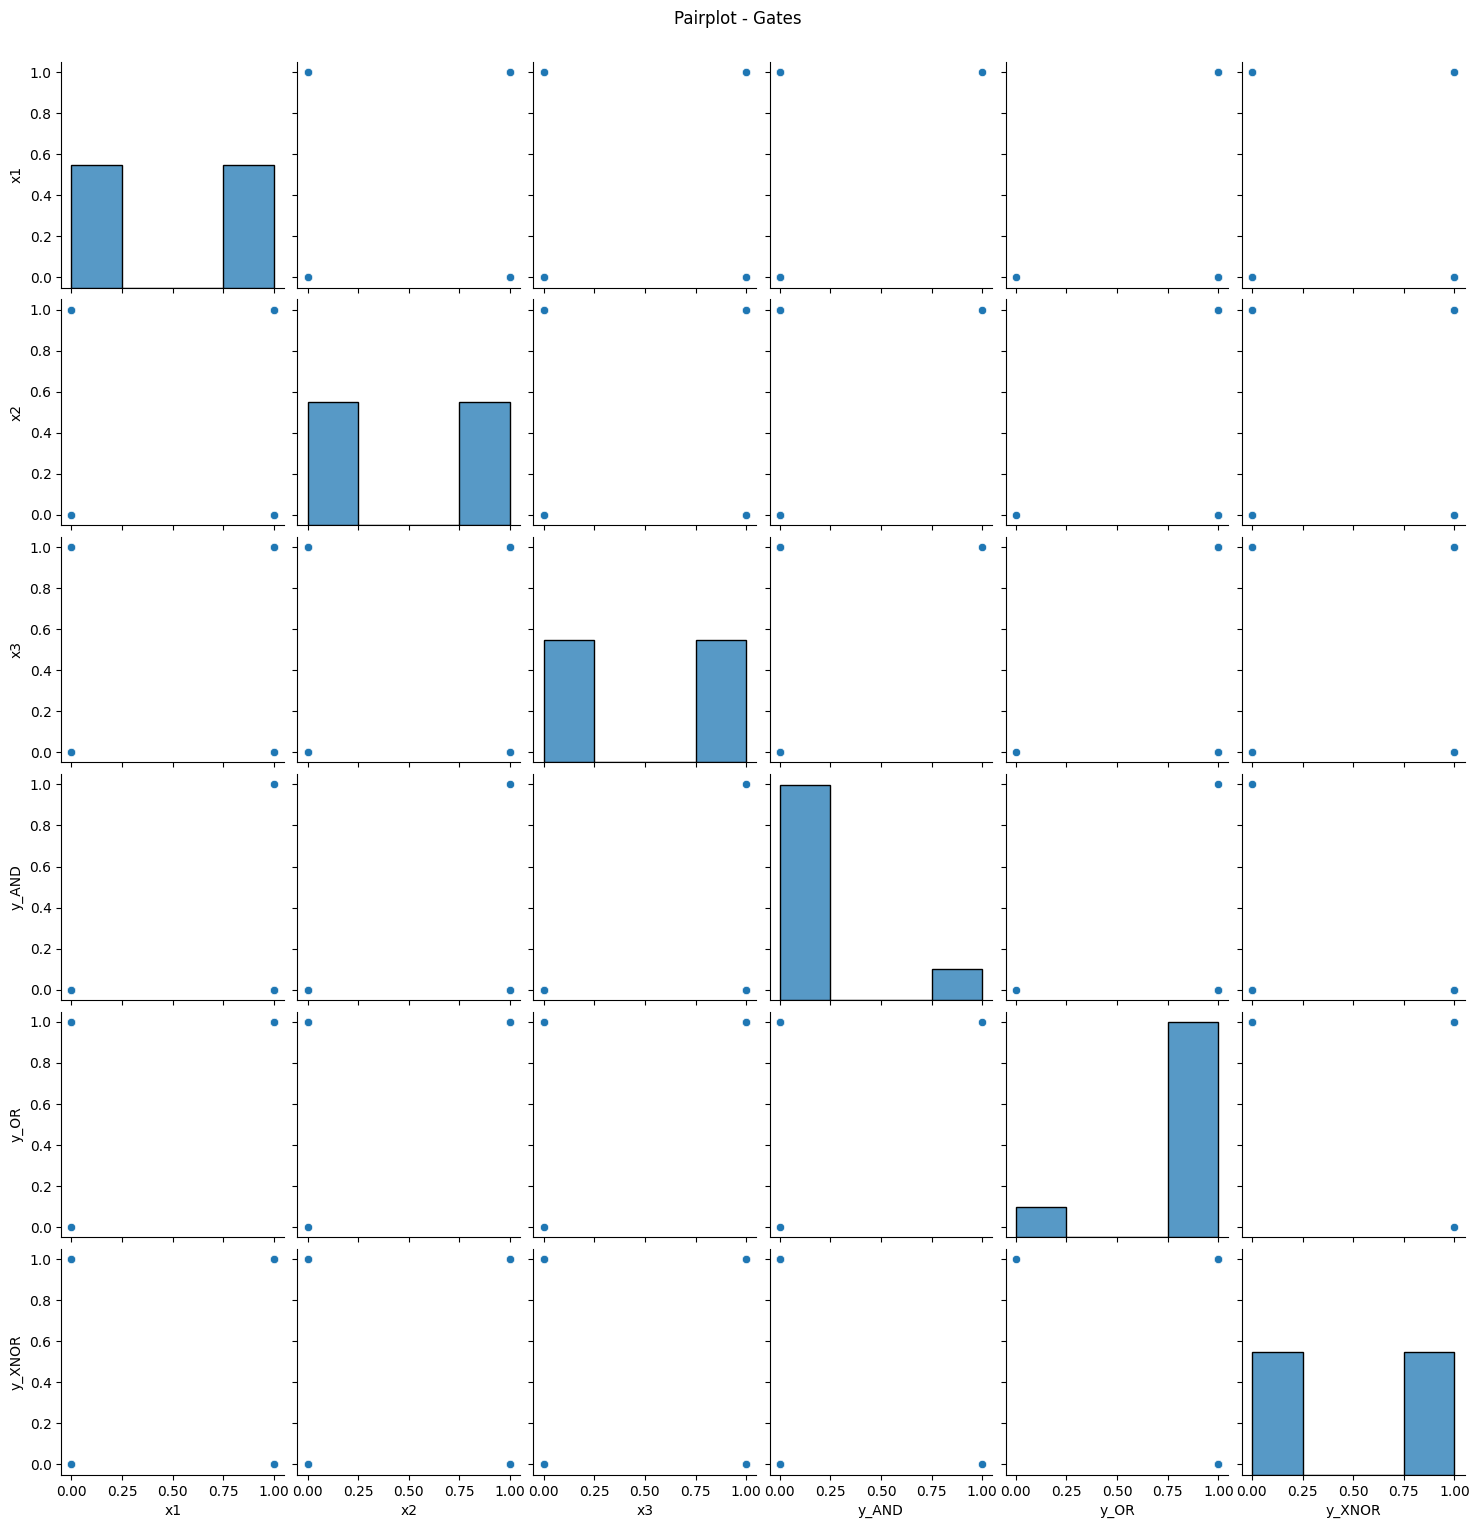

In [14]:
plt.figure(figsize=(8,6))
sns.pairplot(df_gates[["x1","x2","x3","y_AND","y_OR","y_XNOR"]])
plt.suptitle("Pairplot - Gates", y=1.02)
plt.show()

In [15]:
def plot_3d(df, xcol, ycol, zcol, color_by, title=None, savefig=None):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    vals = df[color_by].values
    sc = ax.scatter(df[xcol], df[ycol], df[zcol], c=vals, cmap='viridis', s=80)
    ax.set_xlabel(xcol); ax.set_ylabel(ycol); ax.set_zlabel(zcol)
    plt.title(title or f"3D: {xcol},{ycol},{zcol} colored by {color_by}")
    plt.colorbar(sc, shrink=0.6)
    if savefig:
        plt.savefig(savefig, bbox_inches='tight')
    plt.show()

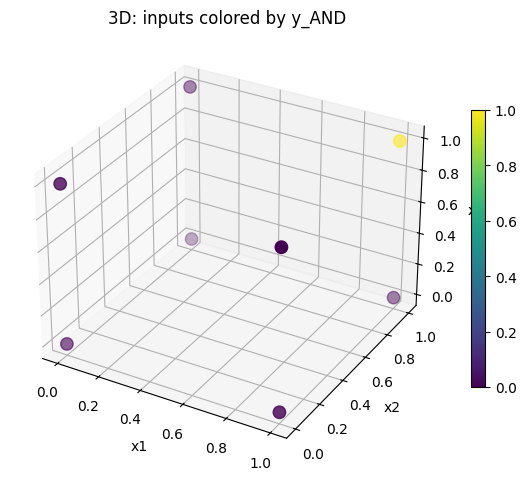

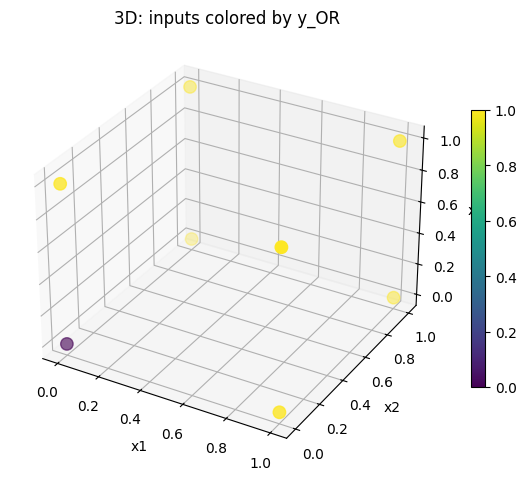

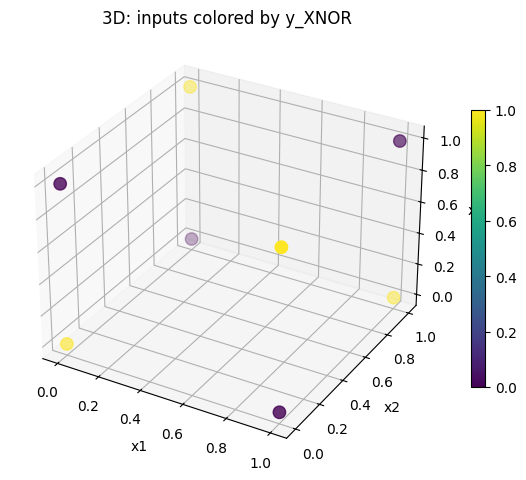

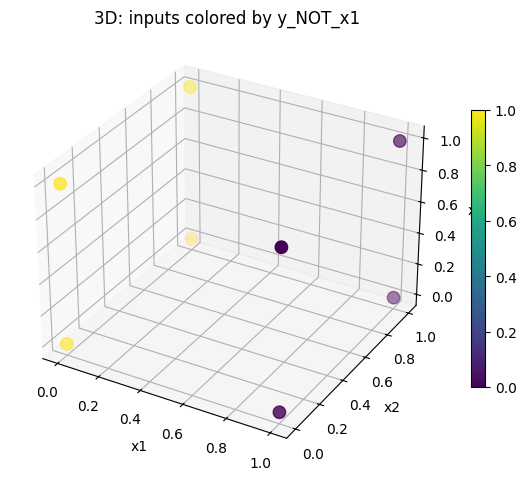

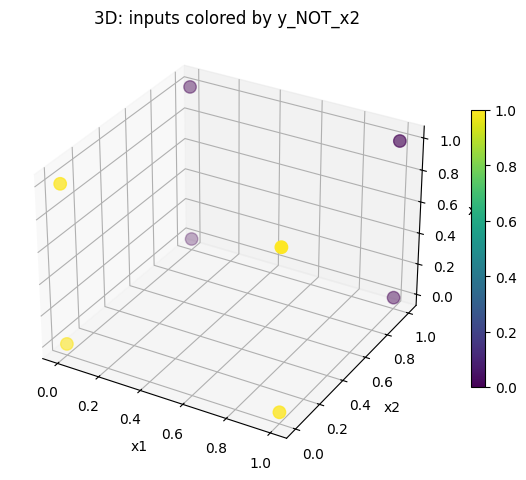

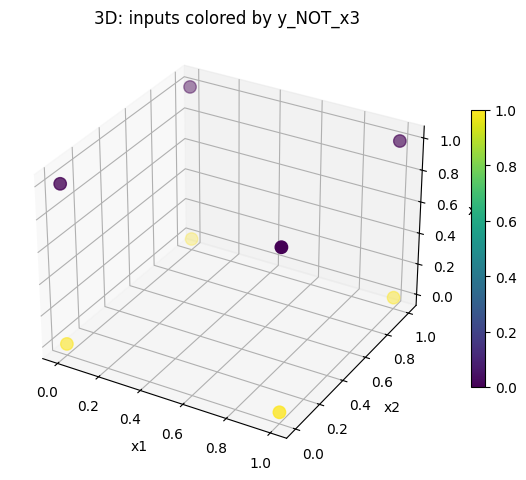

In [16]:
plot_3d(df_gates, "x1", "x2", "x3", color_by="y_AND", title="3D: inputs colored by y_AND")
plot_3d(df_gates, "x1", "x2", "x3", color_by="y_OR", title="3D: inputs colored by y_OR")
plot_3d(df_gates, "x1", "x2", "x3", color_by="y_XNOR", title="3D: inputs colored by y_XNOR")
plot_3d(df_gates, "x1", "x2", "x3", color_by="y_NOT_x1", title="3D: inputs colored by y_NOT_x1")
plot_3d(df_gates, "x1", "x2", "x3", color_by="y_NOT_x2", title="3D: inputs colored by y_NOT_x2")
plot_3d(df_gates, "x1", "x2", "x3", color_by="y_NOT_x3", title="3D: inputs colored by y_NOT_x3")

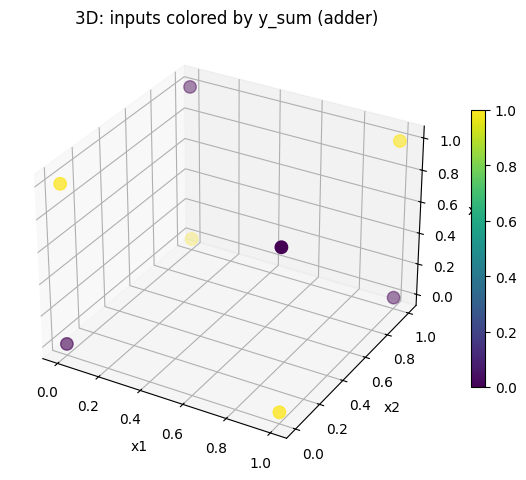

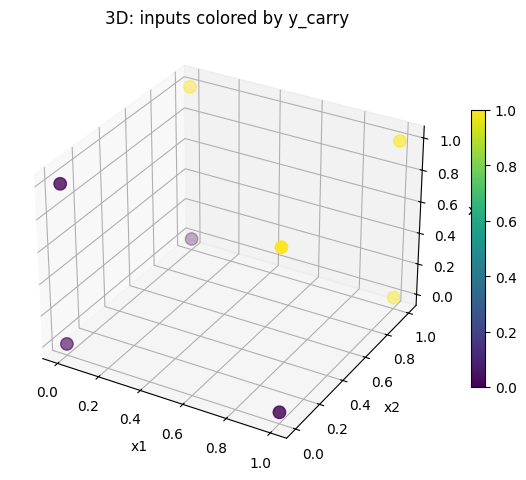

In [17]:
plot_3d(df_adder, "x1", "x2", "x3", color_by="y_sum", title="3D: inputs colored by y_sum (adder)")
plot_3d(df_adder, "x1", "x2", "x3", color_by="y_carry", title="3D: inputs colored by y_carry")

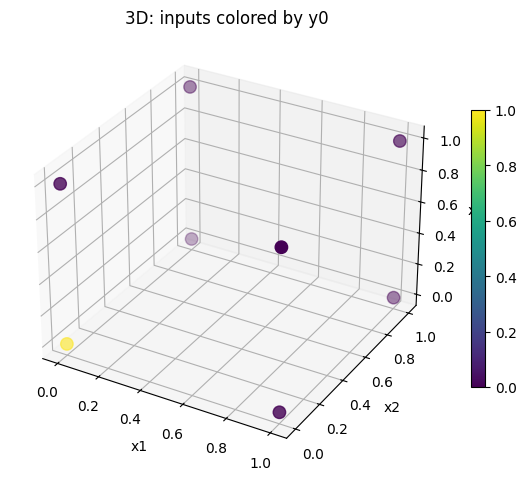

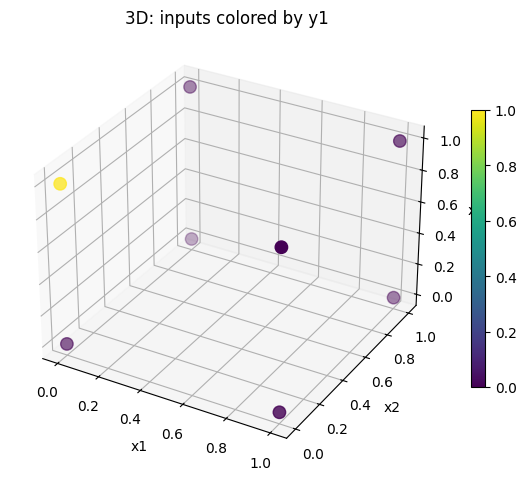

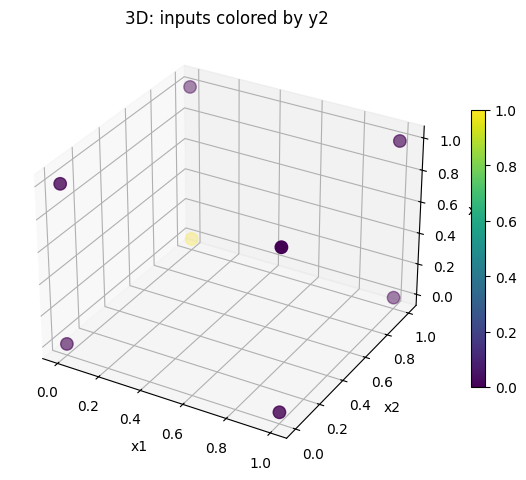

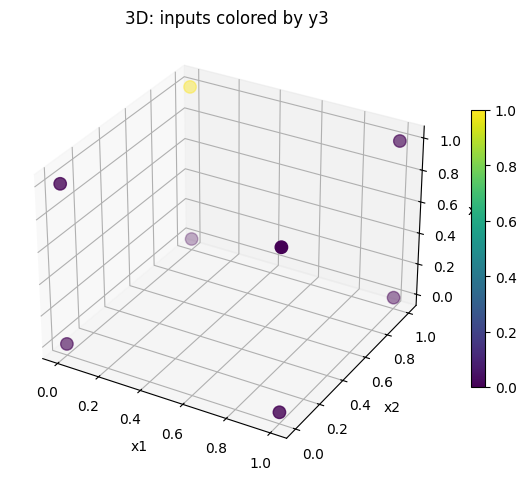

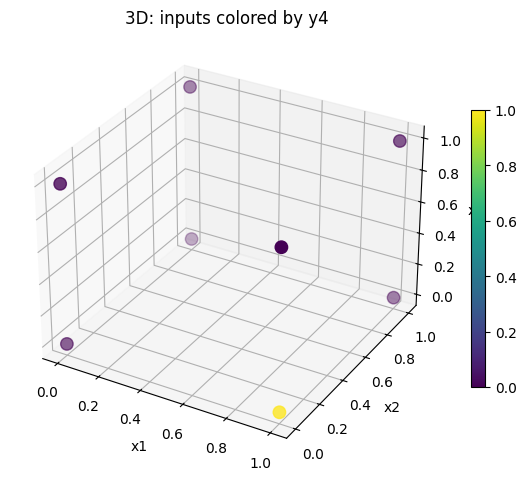

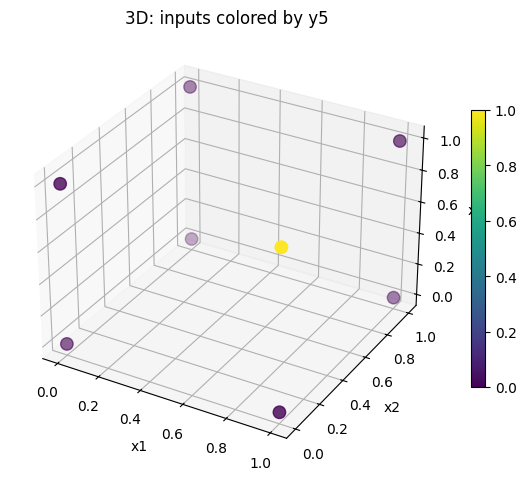

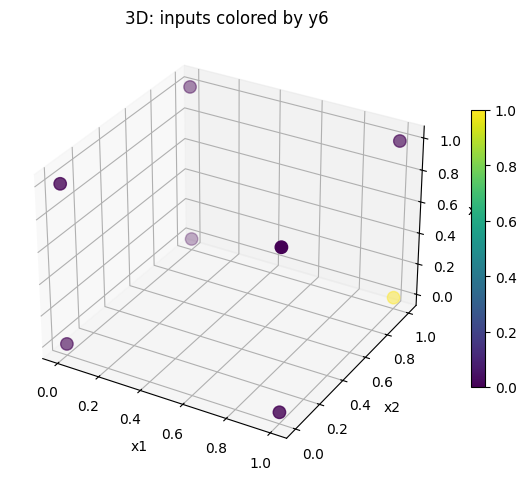

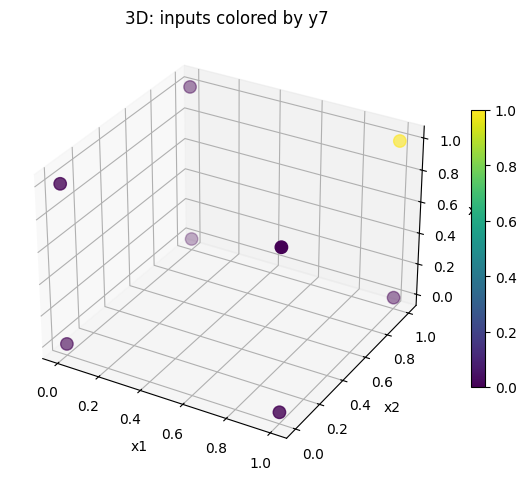

In [18]:
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_0", title="3D: inputs colored by y0")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_1", title="3D: inputs colored by y1")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_2", title="3D: inputs colored by y2")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_3", title="3D: inputs colored by y3")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_4", title="3D: inputs colored by y4")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_5", title="3D: inputs colored by y5")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_6", title="3D: inputs colored by y6")
plot_3d(df_enc_dec["decoder_3to8"], "x1", "x2", "x3", color_by="y_7", title="3D: inputs colored by y7")

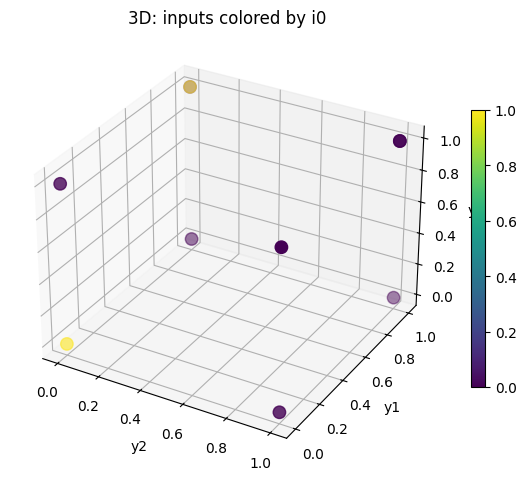

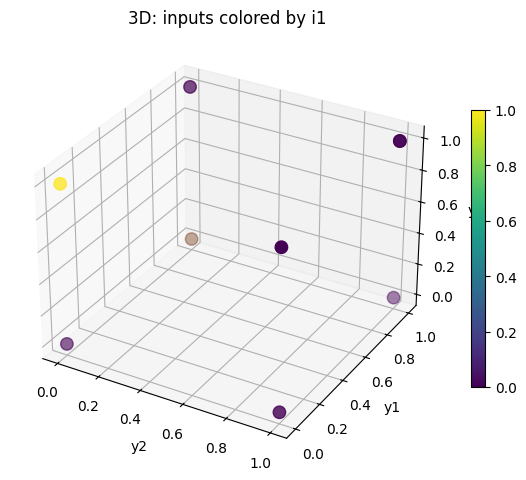

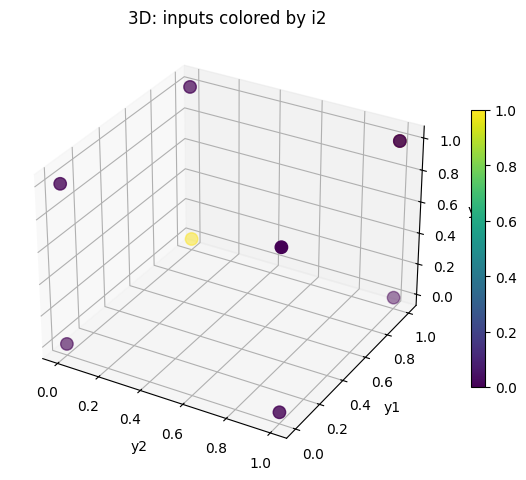

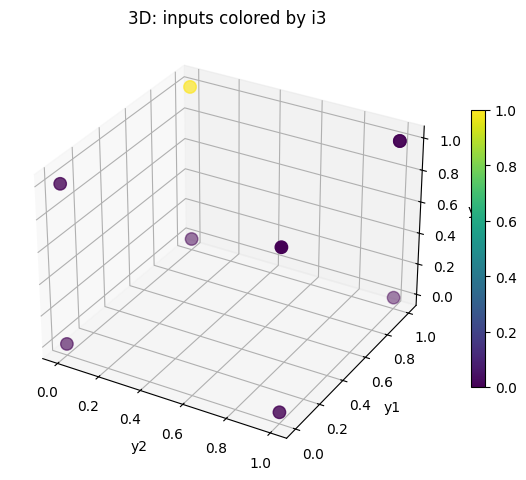

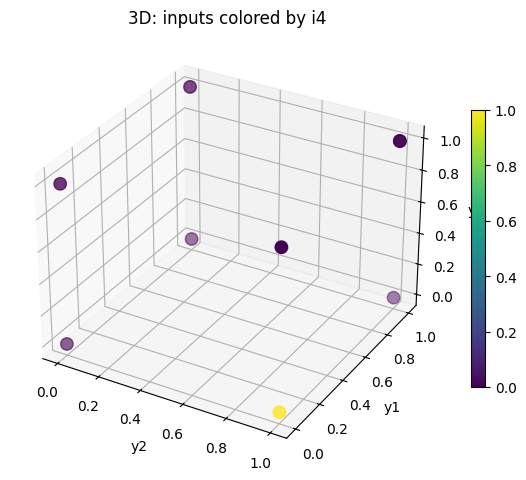

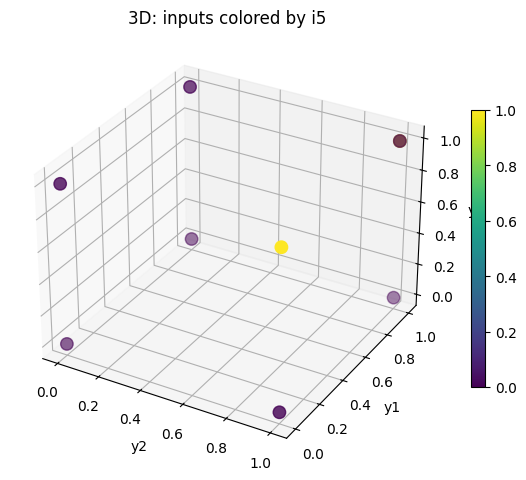

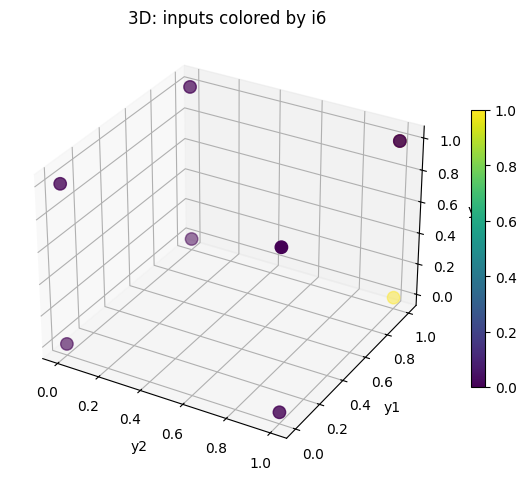

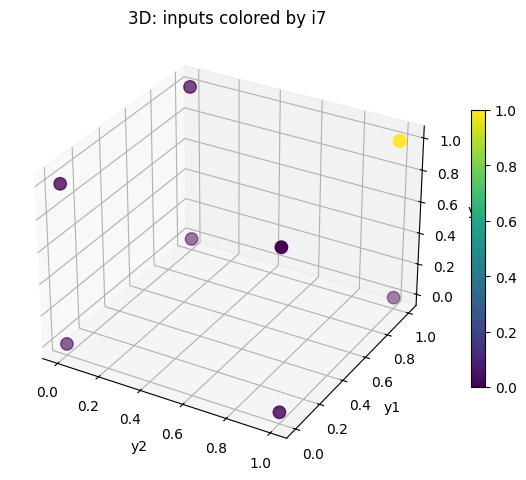

In [19]:
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i0", title="3D: inputs colored by i0")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i1", title="3D: inputs colored by i1")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i2", title="3D: inputs colored by i2")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i3", title="3D: inputs colored by i3")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i4", title="3D: inputs colored by i4")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i5", title="3D: inputs colored by i5")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i6", title="3D: inputs colored by i6")
plot_3d(df_enc_dec['encoder_8to3'], "y2", "y1", "y0", color_by="i7", title="3D: inputs colored by i7")

In [20]:
def train_evaluate_single(X, y, model=None, tune=False, param_grid=None, name="model"):
    if model is None:
        model = RandomForestClassifier(random_state=RANDOM_STATE)

    # Use the full dataset for training since truth tables are tiny
    if tune and param_grid:
        gs = GridSearchCV(model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        gs.fit(X, y)
        best = gs.best_estimator_
        print(f"{name} - Best params: {gs.best_params_}")
    else:
        best = model.fit(X, y)

    # Predict on the same dataset (since it's deterministic mapping)
    y_pred = best.predict(X)

    # Metrics
    metrics = {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0)
    }
    print(f"\n{name} metrics:", metrics)
    print("Confusion matrix:\n", confusion_matrix(y, y_pred))

    # Line plot actual vs predicted
    plt.figure(figsize=(6,3))
    plt.plot(range(len(y)), list(y), label="actual", marker='o')
    plt.plot(range(len(y_pred)), list(y_pred), label="predicted", marker='x')
    plt.title(f"{name} actual vs predicted")
    plt.legend()
    plt.show()

    return best, metrics

In [26]:
def train_evaluate_multi(X, Y, name="multi"):
    base_model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced")
    multi = MultiOutputClassifier(base_model)

    # Fit on full dataset
    best = multi.fit(X, Y)
    y_pred = best.predict(X)

    # Convert to arrays
    y_true = np.array(Y)
    y_pred = np.array(y_pred)
    metrics = {}
    n_outputs = y_true.shape[1]

    for i in range(n_outputs):
        # Metrics per output
        metrics[f"output_{i}"] = {
            "accuracy": accuracy_score(y_true[:, i], y_pred[:, i]),
            "precision": precision_score(y_true[:, i], y_pred[:, i], zero_division=0),
            "recall": recall_score(y_true[:, i], y_pred[:, i], zero_division=0),
            "f1": f1_score(y_true[:, i], y_pred[:, i], zero_division=0)
        }
        print(f"\n{name} - Output {i} metrics:", metrics[f"output_{i}"])
        print("Confusion matrix:\n", confusion_matrix(y_true[:, i], y_pred[:, i]))

        # Line plot actual vs predicted for each output
        plt.figure(figsize=(6,3))
        plt.plot(range(len(y_true[:, i])), y_true[:, i], label="actual", marker='o')
        plt.plot(range(len(y_pred[:, i])), y_pred[:, i], label="predicted", marker='x')
        plt.title(f"{name} - output_{i} actual vs predicted")
        plt.xlabel("Sample index")
        plt.ylabel("Output value")
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

    return best, metrics


=== Modeling: Gates ===

Training for target: y_AND

Gates_y_AND metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


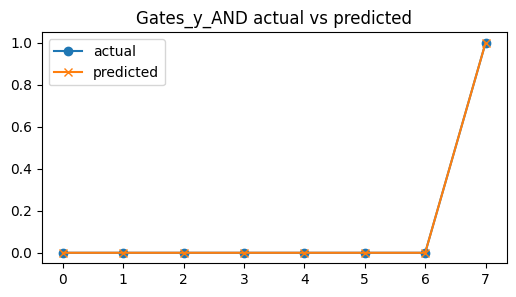


Training for target: y_OR

Gates_y_OR metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[1 0]
 [0 7]]


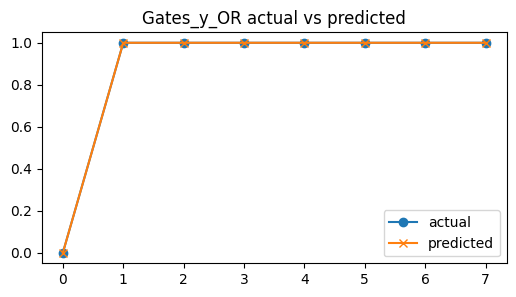


Training for target: y_NOR

Gates_y_NOR metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


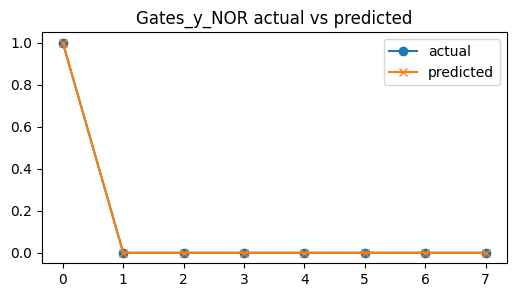


Training for target: y_XNOR

Gates_y_XNOR metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 4]]


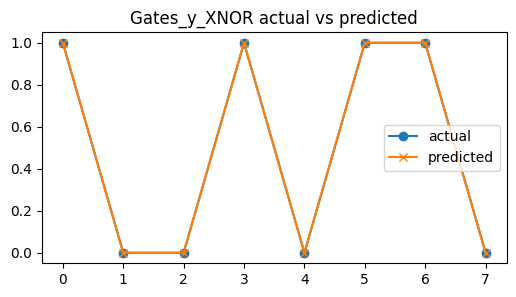


Training for target: y_NOT_x1

Gates_y_NOT_x1 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 4]]


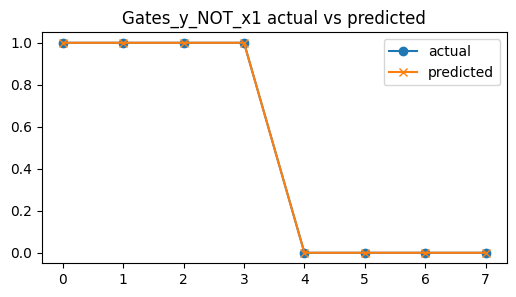


Training for target: y_NOT_x2

Gates_y_NOT_x2 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 4]]


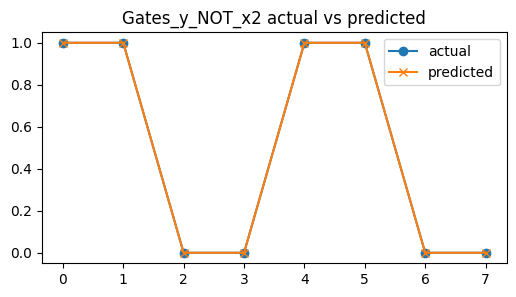


Training for target: y_NOT_x3

Gates_y_NOT_x3 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 4]]


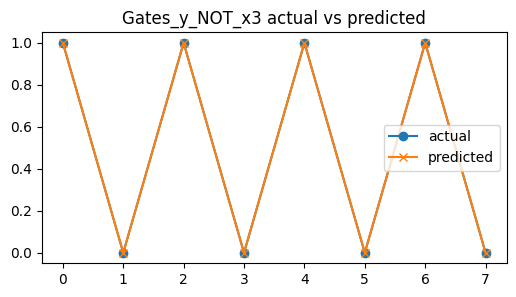

In [27]:
print("\n=== Modeling: Gates ===")
# We'll predict each gate output separately with a simple classifier (RandomForest) and optionally tune small grid.
X_g = df_gates[["x1","x2","x3"]]
for target in ["y_AND","y_OR","y_NOR","y_XNOR","y_NOT_x1","y_NOT_x2","y_NOT_x3"]:
    print(f"\nTraining for target: {target}")
    model, metrics = train_evaluate_single(X_g, df_gates[target], model=RandomForestClassifier(random_state=RANDOM_STATE),
                                          tune=False, param_grid=None, name=f"Gates_{target}")


=== Modeling: 3-bit Adder (sum & carry) ===

Adder_RF_multi - Output 0 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 4]]


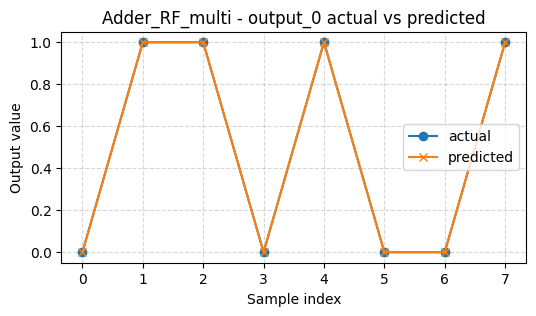


Adder_RF_multi - Output 1 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 4]]


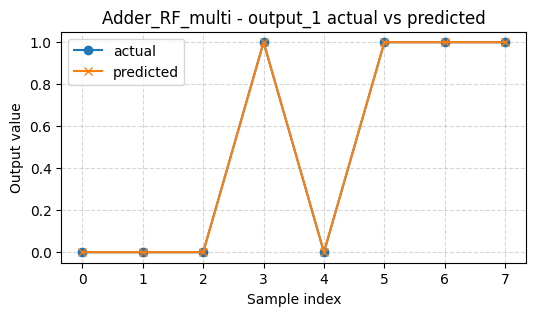

In [28]:
print("\n=== Modeling: 3-bit Adder (sum & carry) ===")
X_a = df_adder[["x1","x2","x3"]]
Y_a = df_adder[["y_sum","y_carry"]]
# Using MultiOutputClassifier with RandomForest; small param grid example
param_grid_adder = {
    # prefix 'estimator__' as MultiOutput wraps estimator
    "estimator__n_estimators": [10, 50],
    "estimator__max_depth": [None, 3]
}
best_adder, metrics_adder = train_evaluate_multi(X_a, Y_a, name="Adder_RF_multi")


=== Modeling: Decoder (3->8 one-hot) ===

Decoder_RF_multi - Output 0 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


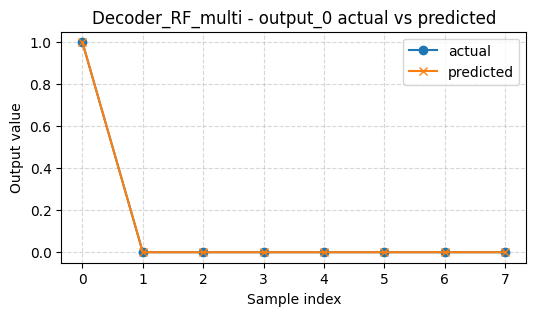


Decoder_RF_multi - Output 1 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


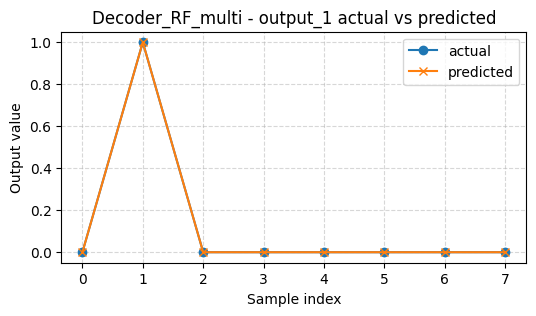


Decoder_RF_multi - Output 2 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


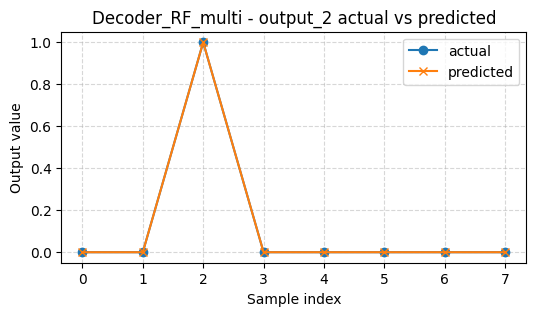


Decoder_RF_multi - Output 3 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


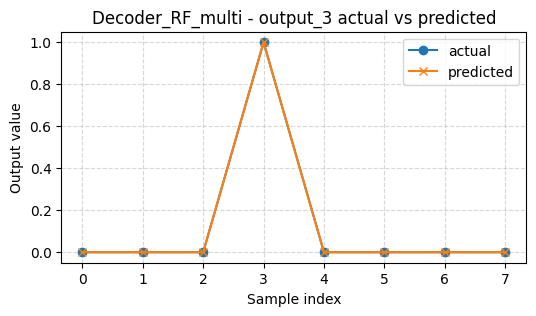


Decoder_RF_multi - Output 4 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


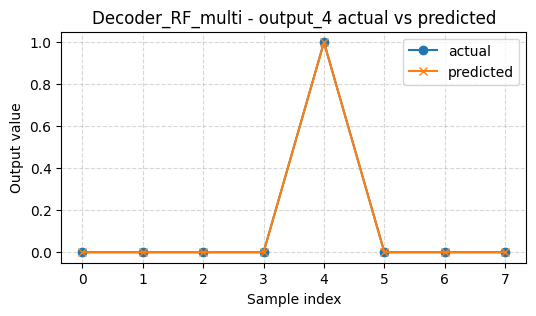


Decoder_RF_multi - Output 5 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


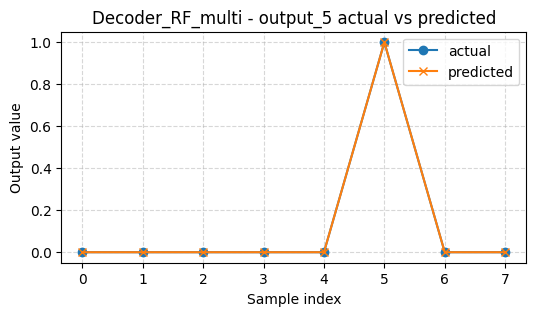


Decoder_RF_multi - Output 6 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


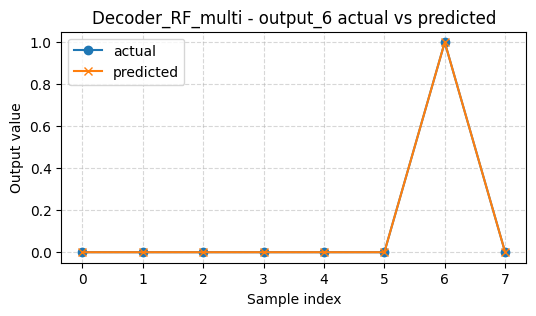


Decoder_RF_multi - Output 7 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[7 0]
 [0 1]]


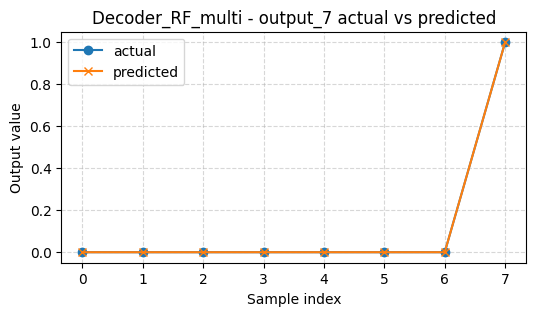

In [29]:
print("\n=== Modeling: Decoder (3->8 one-hot) ===")
X_d = df_decoder[["x1","x2","x3"]]
Y_d = df_decoder[[f"y_{i}" for i in range(8)]]
# Basic grid
param_grid_decoder = {
    "estimator__n_estimators": [10, 50],
    "estimator__max_depth": [None, 3]
}
best_decoder, metrics_decoder = train_evaluate_multi(X_d, Y_d, name="Decoder_RF_multi")


=== Modeling: Encoder (8->3) ===

Encoder_RF_multi - Output 0 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[6 0]
 [0 6]]


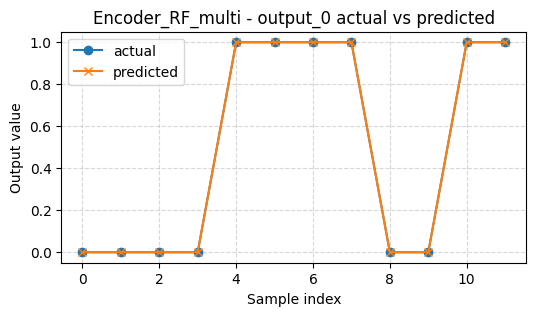


Encoder_RF_multi - Output 1 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[4 0]
 [0 8]]


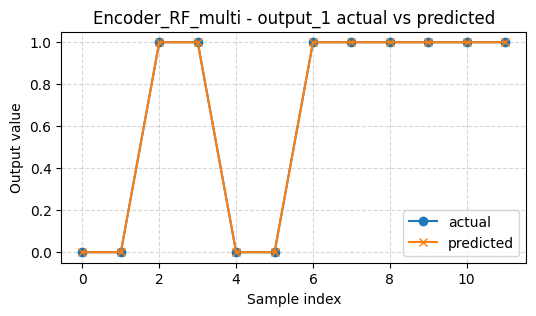


Encoder_RF_multi - Output 2 metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Confusion matrix:
 [[5 0]
 [0 7]]


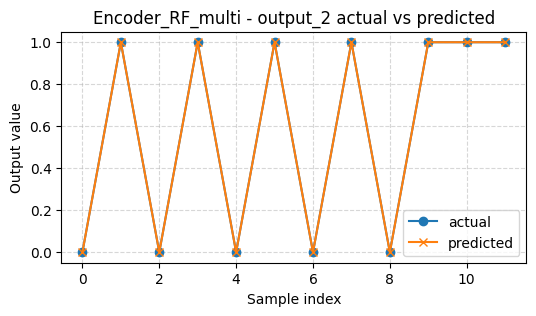

In [30]:
print("\n=== Modeling: Encoder (8->3) ===")
X_e = df_encoder[[f"i{i}" for i in range(8)]]
Y_e = df_encoder[["y2","y1","y0"]]
# Here dataset has multiple rows including multi-hot examples
param_grid_encoder = {
    "estimator__n_estimators": [10, 50],
    "estimator__max_depth": [None, 3]
}
best_encoder, metrics_encoder = train_evaluate_multi(X_e, Y_e, name="Encoder_RF_multi")

In [31]:
def print_metrics(title, metrics):
    print("\n" + "-"*30)
    print(title)
    print("-"*30)
    print(metrics)

In [32]:
print_metrics("Gates: (already printed per-target above)", "See above per-target metrics.")
print_metrics("Adder metrics (multi-output)", metrics_adder)
print_metrics("Decoder metrics (multi-output)", metrics_decoder)
print_metrics("Encoder metrics (multi-output)", metrics_encoder)


------------------------------
Gates: (already printed per-target above)
------------------------------
See above per-target metrics.

------------------------------
Adder metrics (multi-output)
------------------------------
{'output_0': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_1': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}}

------------------------------
Decoder metrics (multi-output)
------------------------------
{'output_0': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_1': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_2': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_3': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_4': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_5': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'output_6': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}, 'o